## Transfer Learning Inception V3

[Abraia](https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5)

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Preparation

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip
!mkdir train
!mv PetImages/* train

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [3]:
!pwd

/content


In [4]:
!ls /content/train

Cat  Dog


## Model customization

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import Model

In [6]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [7]:
from sklearn.model_selection import train_test_split
from glob import glob

In [8]:
cats = glob('/content/train/Cat/*.jpg')
dogs = glob('/content/train/Dog/*.jpg')

cats_train, cats_test = train_test_split(cats, test_size=0.20)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.20)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

In [9]:
!mkdir test

!mkdir /content/test/Cat
files = ' '.join(cats_test)
!mv -t test/Cat $files

!mkdir /content/test/Dogs
files = ' '.join(dogs_test)
!mv -t test/Dogs $files

In [27]:
## All error image that I found
# !rm '/content/train/Dog/Thumbs.db'
# !rm '/content/train/Cat/Thumbs.db'
# !rm '/content/train/Cat/666.jpg'
# !rm '/content/test/Dogs/11702.jpg'
# !rm '/content/train/Dog/11702.jpg'

In [ ]:
# # # Used for clearing error images

# import os
# from PIL import Image
# folder_path = '/content/train/'
# extensions = []
# for fldr in os.listdir(folder_path):
#     sub_folder_path = os.path.join(folder_path, fldr)
#     for filee in os.listdir(sub_folder_path):
#         file_path = os.path.join(sub_folder_path, filee)
#         print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#         im = Image.open(file_path)
#         rgb_im = im.convert('RGB')
#         if filee.split('.')[1] not in extensions:
#             extensions.append(filee.split('.')[1])

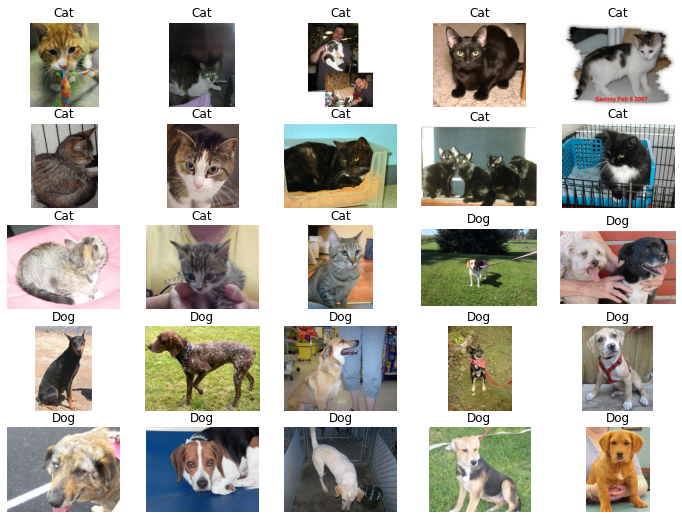

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

cats = np.random.choice(cats_train, 13)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))

labels = 13 * ['Cat'] + 12 * ['Dog']

N, R, C = 255, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
  im = Image.open(src).convert("RGB")
  plt.subplot(R, C, k+1)
  plt.title(label)
  plt.imshow(np.asarray(im))
  plt.axis('off')

In [29]:
CLASSES = 2

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
for layer in base_model.layers:
  layer.trainable = False

In [31]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Data augmentations

In [32]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [33]:
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

In [34]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [35]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


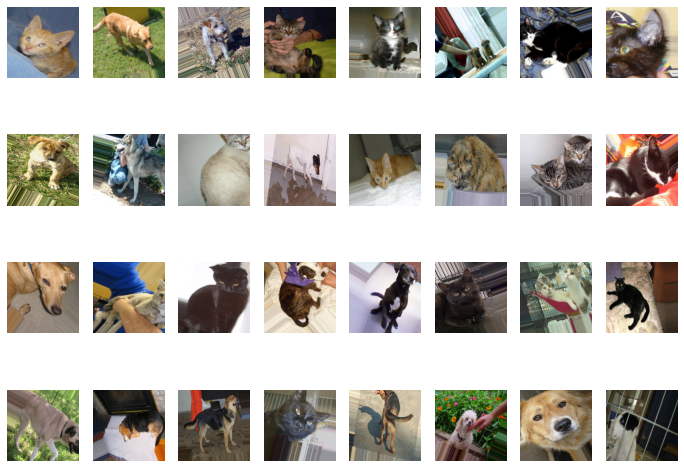

In [36]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12,9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
  plt.subplot(4, 8, k+1)
  plt.imshow((img + 1) / 2)
  plt.axis('off')

## Transfer learning

In [37]:
EPOCHS = 2
BATCH_SIZE = 128
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'dogycat.model'

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS
)

model.save(MODEL_FILE)

Epoch 1/2
170/320 [==============>...............] - ETA: 1:58 - loss: 0.1371 - accuracy: 0.9518

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

320/320 [==============================] - 306s 941ms/step - loss: 0.1019 - accuracy: 0.9655 - val_loss: 0.0406 - val_accuracy: 0.9839
Epoch 2/2
320/320 [==============================] - 295s 923ms/step - loss: 0.0527 - accuracy: 0.9812 - val_loss: 0.0401 - val_accuracy: 0.9854
INFO:tensorflow:Assets written to: dogycat.model/assets


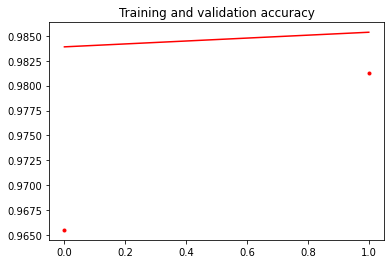

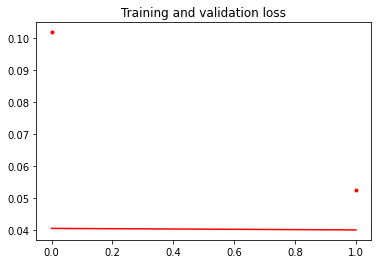

In [41]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

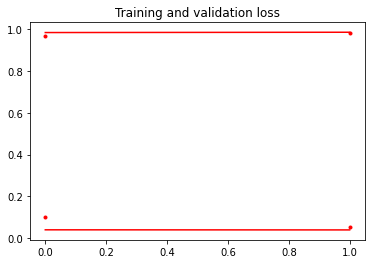

In [40]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

## Prediction

In [45]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

def predict(model, img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  return preds[0]

img = image.load_img('/content/test/Dogs/10.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)

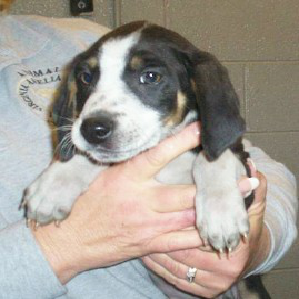

In [47]:
img

In [46]:
preds

array([0.00299641, 0.9970036 ], dtype=float32)

In [48]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing import image
from keras.models import load_model

def predict(model, img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  return preds[0]

def plot_preds(img, preds):
  labels = ('cat', 'dog')
  gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
  plt.figure(figsize=(8,8))
  plt.subplot(gs[0])
  plt.imshow(np.asarray(img))
  plt.subplot(gs[1])
  plt.barh([0,1], preds, alpha=0.5)
  plt.yticks([0,1], labels)
  plt.xlabel('Probability')
  plt.xlim(0,1)
  plt.tight_layout()

In [49]:
model = load_model(MODEL_FILE)

array([0.00299641, 0.9970036 ], dtype=float32)

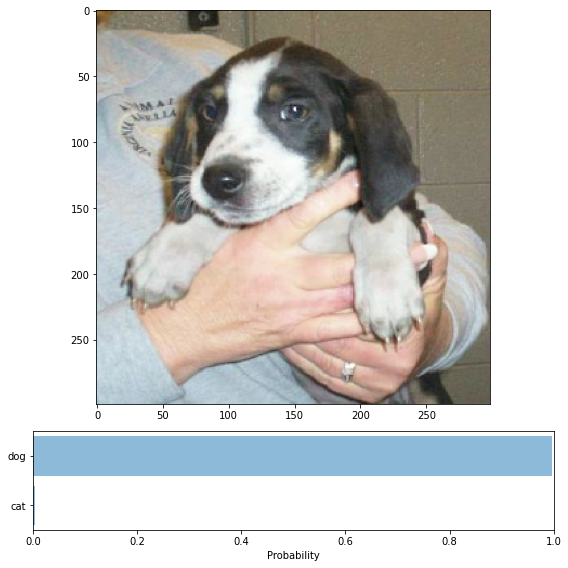

In [51]:
img = image.load_img('test/Dogs/10.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([9.9985158e-01, 1.4843597e-04], dtype=float32)

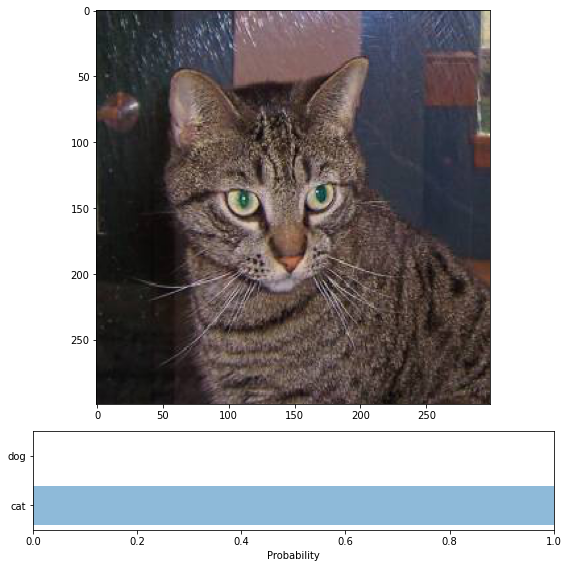

In [52]:
img = image.load_img('test/Cat/1.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [53]:
!ls /content

 dogycat.model		      'MSR-LA - 3467.docx'  'readme[1].txt'   test
 kagglecatsanddogs_3367a.zip   PetImages	     sample_data      train


In [57]:
!zip -r "/content/models.zip" "/content/dogycat.model"

  adding: content/dogycat.model/ (stored 0%)
  adding: content/dogycat.model/variables/ (stored 0%)
  adding: content/dogycat.model/variables/variables.index (deflated 79%)
  adding: content/dogycat.model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/dogycat.model/keras_metadata.pb (deflated 96%)
  adding: content/dogycat.model/saved_model.pb (deflated 92%)
  adding: content/dogycat.model/assets/ (stored 0%)
